First version: 18th of March 2022

Author: Chiara Manini, David Sommer, Darian Viezzer 

Copyright 2022 Charité Universitätsmedizin Berlin.
Copyright 2022 WIAS.

This software was developed during the Math+ “Maths meets Image” hackathon 2022.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance
with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless
required by applicable law or agreed to in writing, software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License
for the specific language governing permissions and limitations under the License.

# PART 1 : SEGMENTATION + NOISE ADD

In [1]:
import os
import sys
import copy
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torch

%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import data_augmentation
from NN_segmentation.tst_dataset import cardiacdata
from NN_segmentation.UNET3D_D4 import UNet3D
from NN_segmentation.Auto3D_D4 import Auto3D
import numpy as np

In [2]:
# LOAD DATA
path_data = r"/home/jovyan/project_data/ACDC-Daten"
add_noise = True
single_noise_probability = 50

data_list = []
label_list = []

for root, _, files in os.walk(path_data):
    if os.path.isfile(os.path.join(root, "image.nii.gz")):
        try:
            data_list.append(cardiacdata(img_dir=os.path.join(root, "image.nii.gz"), label_dir=os.path.join(root, "label.nii.gz")))
        except:
            pass
        
data_noise = []#copy.deepcopy(data_list)
for i in range(len(data_list)):
    noisy_data = []
    for j in range(data_list[i].img.shape[0]):
        for k in range(data_list[i].img.shape[1]):
            noisy_data.append(data_augmentation.augmentation(np.squeeze(data_list[i].img[j,k,:,:]), single_noise_probability))
    data_noise.append(np.array(noisy_data).reshape(data_list[i].img.shape))
    
data_noisy_list = copy.deepcopy(data_list)
for i in range(len(data_list)):
    data_noisy_list[i].img = data_noise[i]

In [3]:
#for num in range(len(data_list)):
#    fig, axes = plt.subplots(1, 2)
#    axes[0].imshow(np.squeeze(data_list[num].img[0,0,:,:]), cmap="gray")
#    axes[0].axis("off")
#    axes[1].imshow(np.squeeze(data_noisy_list[num].img[0,0,:,:]), cmap="gray")
#    axes[1].axis("off")
#    plt.show()

In [6]:
# RUN SEGMENTATION
use_model = "AE" # AE or UNET
use_data = "ORIG" # ORIG or NOISY

if use_data == "ORIG":
    data = data_list
else:
    data = data_noisy_list


# network
if use_model == "AE":
    MDL_PATH=r"/home/jovyan/project_segmentation_models/19"
    net = Auto3D(num_classes=4, in_channels=1, depth=4, start_filts=32, res=False).cuda()
else:
    MDL_PATH=r"/home/jovyan/project_segmentation_models/20"
    net = UNet3D(num_classes=4, depth=4, start_filts=32, in_channels=1, res=True).cuda()

with torch.no_grad():
    net.load_state_dict(torch.load(os.path.join(MDL_PATH, "model_best.pth.tar"))['state_dict'])

    normOrg_list=[]
    normGT_list=[]
    normSeg_list=[]
    normError_list = []

    net.eval()
    for i in range(len(data)):
        tst_loader = DataLoader(data[i], batch_size=1, shuffle=False, num_workers=0)
        img_shape = data[i].img.shape
        normOrg=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.float32)
        normGT=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.int16)
        normSeg=np.zeros((1,img_shape[1],img_shape[2],img_shape[3]),dtype=np.int16)
        #dice = np.zeros((1, 3))

        for step, (img, seg_gt) in enumerate(tst_loader, 0):
            img, seg_gt = img.cuda(), seg_gt.cuda()
            pred = net(img)
            _, pred = torch.max(pred, 1)

            pred = pred.squeeze().detach().cpu().numpy().astype(np.int8)
            img = img.squeeze().detach().cpu().numpy()
            gt = seg_gt.squeeze().detach().cpu().numpy().astype(np.int8)
            #for j in range(3):
            #    dice[step, j] = dice_comp(pred==j+1, gt==j+1)
            normOrg[step]=copy.deepcopy(img)
            normGT[step]=copy.deepcopy(gt)
            normSeg[step]=copy.deepcopy(pred)

            torch.cuda.empty_cache()

        normOrg=np.reshape(normOrg,[int(normOrg.shape[1]/8),8,144,144])
        normGT=np.reshape(normGT,[int(normGT.shape[1]/8),8,144,144])
        normSeg=np.reshape(normSeg,[int(normSeg.shape[1]/8),8,144,144])
        normError=np.abs(normGT.astype(np.float32)-normSeg.astype(np.float32))
        normOrg=normOrg-normOrg.min()

        normOrg_list.append(normOrg)
        normGT_list.append(normGT)
        normSeg_list.append(normSeg)
        normError_list.append(normError)
print("ok")

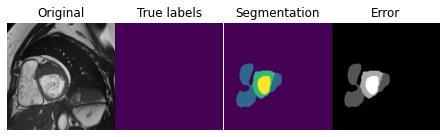

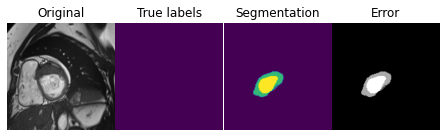

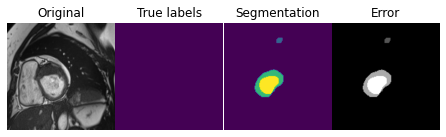

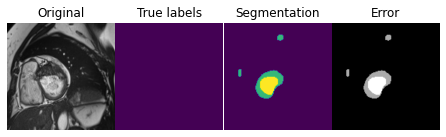

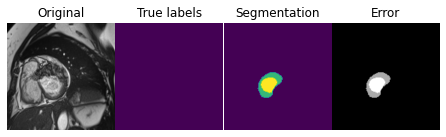

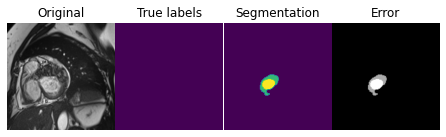

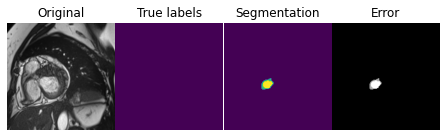

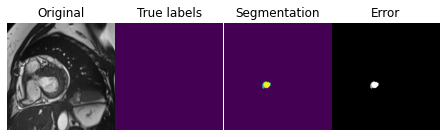

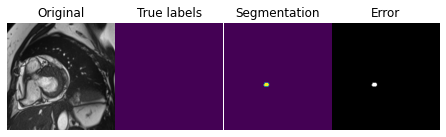

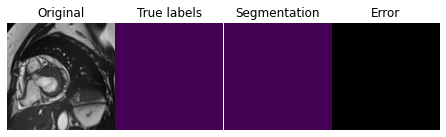

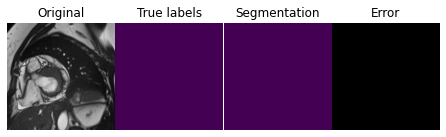

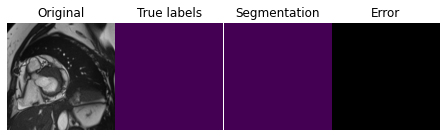

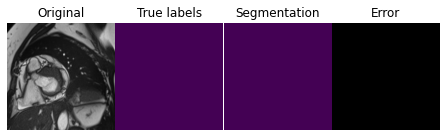

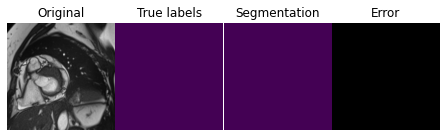

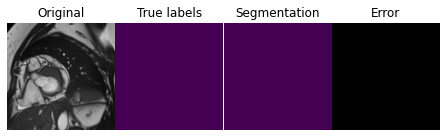

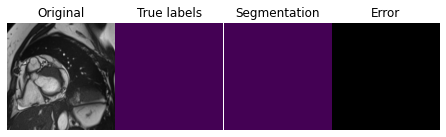

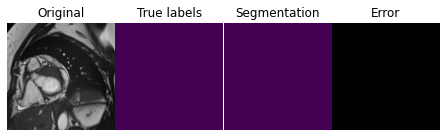

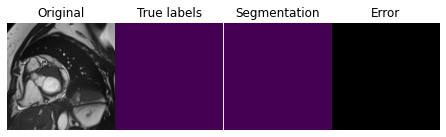

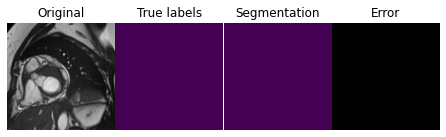

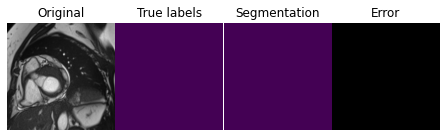

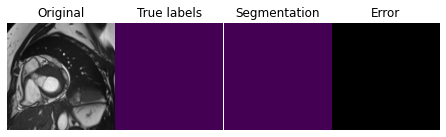

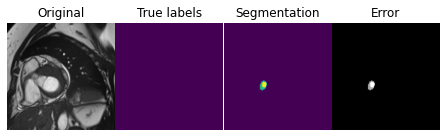

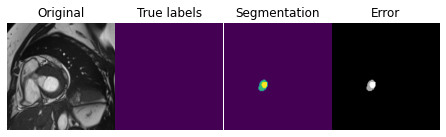

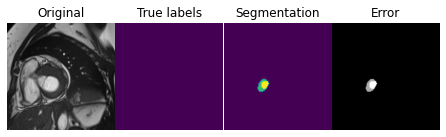

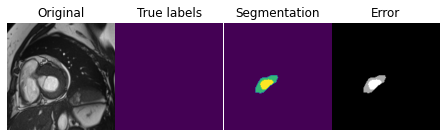

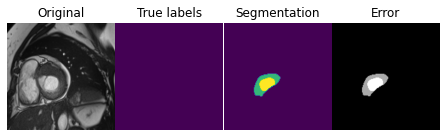

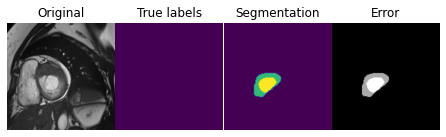

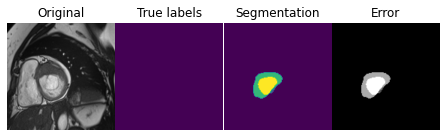

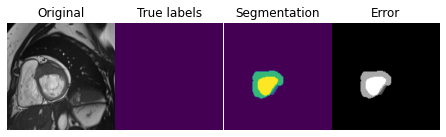

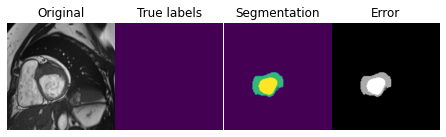

In [8]:
#%% Display the output images
index = 0
vol_slice = 0
for dispind in range(normOrg_list[index].shape[0]):
    plot= lambda x: plt.imshow(x,cmap=plt.cm.gray,interpolation='bilinear')
    plot1= lambda x: plt.imshow(x,interpolation='bilinear')
    plt.clf()
    plt.subplot(141)
    plot(np.abs(normOrg_list[index][dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('Original')
    plt.subplot(142)
    plot1(np.abs(normGT_list[index][dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('True labels')
    plt.subplot(143)
    plot1(np.abs(normSeg_list[index][dispind,vol_slice,:,:]))
    plt.axis('off')
    plt.title('Segmentation')
    plt.subplot(144)
    plot(np.abs(normError_list[index][dispind,vol_slice,:,:]))
    plt.title('Error')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=.01)
    plt.show()
# purple=0, blue=1, green=2, yellow=3